In [12]:
from numpy import *
from matplotlib.pylab import *
import matplotlib.pylab as plt
import sklearn.cluster as clt
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

In [5]:
from Optics import OPTICS

In [6]:
# #############################################################################
# Generate random sample data
#centers = [[1, 1,5,2], [-1, -1,3,4], [1, -1,2,4]]
#X, _ = make_blobs(n_samples=750, centers=centers, cluster_std=0.4,
#                            random_state=0)

# Change X to real statistical data for spines
file = "stats_Fullset_20190306.dat"
X = loadtxt(file)
X = X[isfinite(X[:,3]),:]

In [7]:
X = StandardScaler().fit_transform(X)
X.shape

(86382, 7)

In [8]:
###############################################################################
# Compute OPTICS

op = OPTICS(max_eps=1.0, min_samples=10).fit(X)

/users/bssn/serna/environments/deepl/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Warning, max_eps (1.0) is close to eps (0.5): Output may be unstable.
  after removing the cwd from sys.path.


In [11]:
op.__dict__

{'max_eps': 1.0,
 'min_samples': 10,
 'min_cluster_size': 0.005,
 'algorithm': 'auto',
 'metric': 'minkowski',
 'metric_params': None,
 'p': 2,
 'leaf_size': 30,
 'cluster_method': 'dbscan',
 'eps': 0.5,
 'n_jobs': None,
 'ordering_': array([    0,     1,  2933, ..., 84966, 86073, 86132]),
 'core_distances_': array([       inf, 0.48655706, 0.35864293, ..., 0.41030725, 0.47429971,
        0.33913074]),
 'reachability_': array([       inf,        inf, 0.31601163, ..., 0.35010542, 0.42047195,
        0.29674118]),
 'predecessor_': array([   -1,    -1,  2941, ..., 47557, 77357, 75099]),
 'labels_': array([-1,  0,  0, ...,  0,  0,  0])}

In [15]:
import matplotlib.gridspec as gridspec

Text(0.5,1,'Automatic opering\nOPTICS')

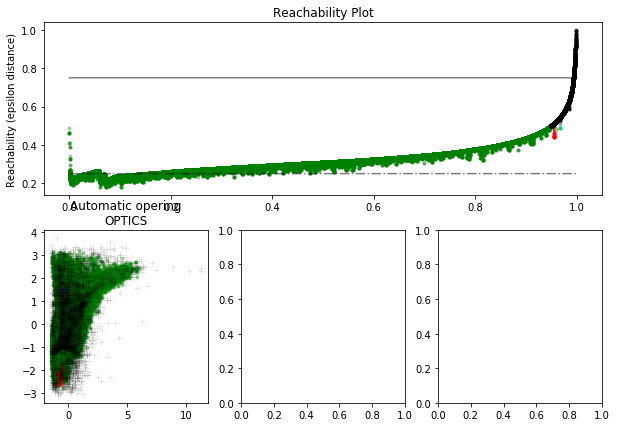

In [20]:

#_, labels_025 = op.extract_dbscan(0.25)
#_, labels_075 = op.extract_dbscan(0.75)

space = np.arange(len(X))
reachability = op.reachability_[op.ordering_]
labels = op.labels_[op.ordering_]

plt.figure(figsize=(10, 7))
G = gridspec.GridSpec(2, 3)
ax1 = plt.subplot(G[0, :])
ax2 = plt.subplot(G[1, 0])
ax3 = plt.subplot(G[1, 1])
ax4 = plt.subplot(G[1, 2])

# Reachability plot
color = ['g.', 'r.', 'b.', 'y.', 'c.']
for k, c in zip(range(0, 5), color):
    Xk = space[labels == k]
    Rk = reachability[labels == k]
    ax1.plot(Xk/X.shape[0], Rk, c, alpha=0.3)
ax1.plot(space[labels == -1]/X.shape[0], reachability[labels == -1], 'k.', alpha=0.3)
ax1.plot(space/X.shape[0], np.full_like(space, 0.75, dtype=float), 'k-', alpha=0.5)
ax1.plot(space/X.shape[0], np.full_like(space, 0.25, dtype=float), 'k-.', alpha=0.5)
ax1.set_ylabel('Reachability (epsilon distance)')
ax1.set_title('Reachability Plot')

# OPTICS
color = ['g.', 'r.', 'b.', 'y.', 'c.']
for k, c in zip(range(0, 5), color):
    Xk = X[op.labels_ == k]
    ax2.plot(Xk[:, 0], Xk[:, 1], c, alpha=0.3)
ax2.plot(X[op.labels_ == -1, 0], X[op.labels_ == -1, 1], 'k+', alpha=0.1)
ax2.set_title('Automatic opering\nOPTICS')

# DBSCAN at 0.25
#color = ['g', 'greenyellow', 'olive', 'r', 'b', 'c']
#for k, c in zip(range(0, 6), color):
#    Xk = X[labels_025 == k]
#    ax3.plot(Xk[:, 0], Xk[:, 1], c, alpha=0.3, marker='.')
#ax3.plot(X[labels_025 == -1, 0], X[labels_025 == -1, 1], 'k+', alpha=0.1)
#ax3.set_title('opering at 0.25 epsilon cut\nDBSCAN')

# DBSCAN at 0.75
#color = ['g.', 'm.', 'y.', 'c.']
#for k, c in zip(range(0, 4), color):
#    Xk = X[labels_075 == k]
#    ax4.plot(Xk[:, 0], Xk[:, 1], c, alpha=0.3)
#ax4.plot(X[labels_075 == -1, 0], X[labels_075 == -1, 1], 'k+', alpha=0.1)
#ax4.set_title('opering at 0.75 epsilon cut\nDBSCAN')


In [17]:
set(op.labels_)

{-1, 0, 1, 2, 3, 4}

In [21]:
# #############################################################################
# Compute DBSCAN
ee = arange(0.4,0.8,0.01)
data = zeros((ee.shape[0],3))
for i,e in enumerate(ee):
    db = DBSCAN(eps=e, min_samples=10).fit(X)
    core_samples_mask = zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    slet = metrics.silhouette_score(X, labels)
    data[i,:] = (n_clusters, n_noise, slet)

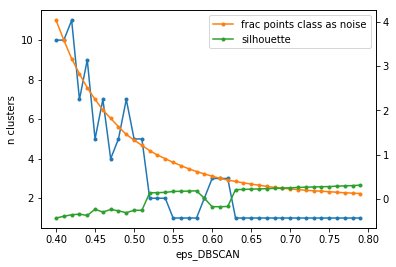

In [22]:
fig, ax1 = subplots()
plot(ee,data[:,0],'.-',label='n clusters')
ylabel("n clusters")
xlabel("eps_DBSCAN")
ax2 = ax1.twinx()
plot(ee,data[:,1]/3226,'C1.-', label='frac points class as noise')
plot(ee,data[:,2],'C2.-', label='silhouette')
ylabel("")
legend()
#print('Estimated number of clusters: %d' % n_clusters_)
#print('Estimated number of noise points: %d' % n_noise_)
#print("Silhouette Coefficient: %0.3f"
#     % metrics.silhouette_score(X, labels))

In [24]:
e = float(input("Input optimal eps from previous figure "))
db = DBSCAN(eps=e, min_samples=10).fit(X)
core_samples_mask = zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)
slet = metrics.silhouette_score(X, labels)
print('Estimated number of clusters: %d' % n_clusters)
print('Estimated number of noise points: %d' % n_noise)
print("Silhouette Coefficient: %0.3f"
     % metrics.silhouette_score(X, labels))

Input optimal eps from previous figure 0.6
Estimated number of clusters: 3
Estimated number of noise points: 1670
Silhouette Coefficient: -0.169


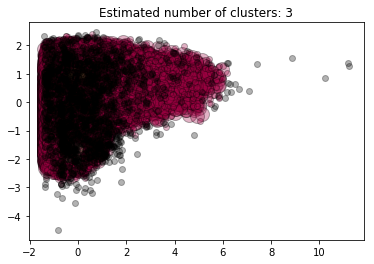

In [26]:
# #############################################################################
# Plot result
from matplotlib.pylab import cm
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [cm.Spectral(each) for each in linspace(0, 1, len(unique_labels))]
ncol = [0,6]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plot(xy[:, ncol[0]], xy[:, ncol[1]], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14,alpha=0.3)

    xy = X[class_member_mask & ~core_samples_mask]
    plot(xy[:, ncol[0]], xy[:, ncol[1]], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6,alpha=0.3)

title('Estimated number of clusters: %d' % n_clusters)
show()